## FMA dimensionality reduction - PCA

In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
import IPython.display as ipd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import (PCA, KernelPCA)
from sklearn.manifold import (TSNE, Isomap)

import matplotlib.pyplot as plt
import seaborn as sns

import utils

RANDOM_STATE=53

#### Load features and tracks

In [8]:
(features, tracks) = utils.load_features()
features.shape, tracks.shape

((106574, 518), (106574, 52))

In [9]:

features.columns.get_level_values(0).unique()

Index(['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse',
       'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast',
       'spectral_rolloff', 'tonnetz', 'zcr'],
      dtype='object', name='feature')

#### Run PCA and examine contributions of Principal Components

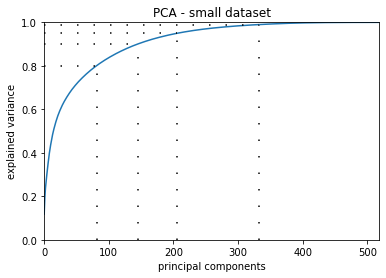

In [81]:
def plot_cum_pca(df, title):
    X = StandardScaler().fit_transform(df)

    pca = PCA(random_state=RANDOM_STATE)
    pca.fit(X)
    cum_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(cum_variance)
    plt.title(title)
    plt.xlabel('principal components')
    plt.ylabel('explained variance')
    plt.ylim([0,1])
    plt.xlim([0,len(cum_variance)])
    idx_80 = -1
    idx_90 = -1
    idx_95 = -1
    idx_99 = -1

    for i in range(len(cum_variance)):
        if idx_80 < 0 and cum_variance[i] > .80:
            idx_80 = i
        if idx_90 < 0 and cum_variance[i] > .90:
            idx_90 = i
        if idx_95 < 0 and cum_variance[i] > .95:
            idx_95 = i
        if idx_99 < 0 and cum_variance[i] > .99:
            idx_99 = i

    for idx in [idx_80, idx_90, idx_95, idx_99]:
        plt.plot([idx, idx], [0, cum_variance[idx]], ls=(0, (1, 10)), color='k')
        plt.plot([0, idx], [cum_variance[idx], cum_variance[idx]], ls=(0, (1, 10)), color='k')


small = tracks['set', 'subset'] == 'small'
medium = tracks['set', 'subset'] == 'medium'

plot_cum_pca(features[small], 'PCA - small dataset')




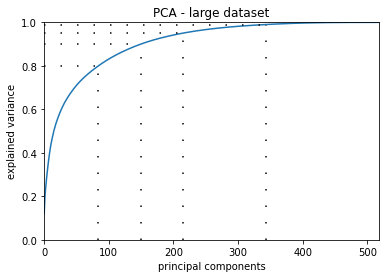

In [82]:
plot_cum_pca(features, 'PCA - large dataset')


### Does using PCA to reduce dimensions somewhat help with Isomap or TSNE?

#### Maybe?

In [84]:
df = features[small]
X = StandardScaler().fit_transform(df)

pca = PCA(random_state=RANDOM_STATE, n_components=100)
X_t = pca.fit_transform(X)

y = tracks[small][('track','genre_top')]

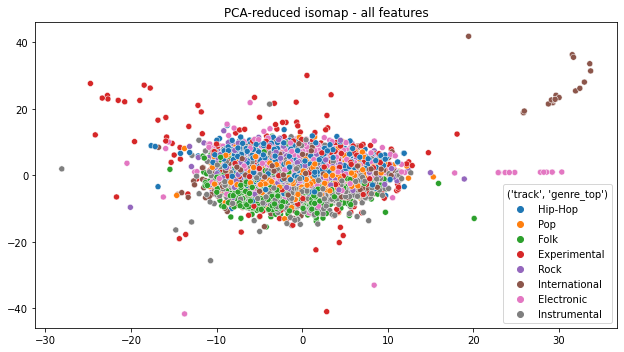

In [95]:
utils.estimate_all_features(X_t, y, 'PCA-reduced isomap', Isomap(n_components=2, n_jobs=-1))

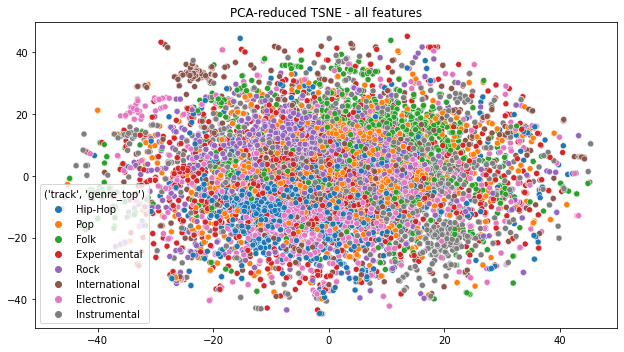

In [93]:
utils.estimate_all_features(X_t, y, 'PCA-reduced TSNE', TSNE(n_components=2, perplexity=50))

### PCA for dimensionality reduction before SVM

little impact

In [87]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import IPython.display as ipd

import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV

X_train, X_test, y_train, y_test = train_test_split(df, y, 
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(random_state=RANDOM_STATE, n_components=150)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svc = SVC(kernel='rbf', random_state=RANDOM_STATE)
svc.fit(X_train_scaled, y_train)
y_pred = svc.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

   Electronic       0.61      0.62      0.61       200
 Experimental       0.45      0.49      0.47       200
         Folk       0.64      0.71      0.67       200
      Hip-Hop       0.64      0.70      0.67       200
 Instrumental       0.54      0.55      0.55       200
International       0.79      0.68      0.73       200
          Pop       0.48      0.39      0.43       200
         Rock       0.69      0.69      0.69       200

     accuracy                           0.60      1600
    macro avg       0.60      0.60      0.60      1600
 weighted avg       0.60      0.60      0.60      1600



In [88]:
svc = SVC(kernel='rbf', random_state=RANDOM_STATE)
svc.fit(X_train_pca, y_train)
y_pred = svc.predict(X_test_pca)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

   Electronic       0.60      0.62      0.61       200
 Experimental       0.46      0.48      0.47       200
         Folk       0.64      0.71      0.67       200
      Hip-Hop       0.61      0.70      0.65       200
 Instrumental       0.57      0.57      0.57       200
International       0.79      0.67      0.72       200
          Pop       0.45      0.35      0.40       200
         Rock       0.67      0.68      0.67       200

     accuracy                           0.60      1600
    macro avg       0.60      0.60      0.60      1600
 weighted avg       0.60      0.60      0.60      1600

